# Lagged cross-covariance analysis

Resolution: 1-degree, weekly

---

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [4]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("white")

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [7]:
# Cut datasets to a regular grid and resample to weekly averages within each grid cell
df_sif_weekly = (
    utils.regrid(DS_sif, res=1)
    .groupby(["lon", "lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_weekly = (
    utils.regrid(DS_xco2, res=1)
    .groupby(["lon", "lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_weekly = pd.merge(df_sif_weekly, df_xco2_weekly, on=["lon", "lat", "time"], how="outer")
df_grid_weekly

,lon,lat,time,sif,xco2
0,-179.5,-85.5,2014-11-30,0.009041,NaN
1,-179.5,-85.5,2014-12-07,-0.121515,NaN
2,-179.5,-85.5,2014-12-14,-0.117814,NaN
3,-179.5,-85.5,2014-12-21,NaN,NaN
4,-179.5,-85.5,2014-12-28,NaN,NaN
...,...,...,...,...,...
6818202,173.5,-35.5,2020-04-19,NaN,NaN
6818203,173.5,-35.5,2020-04-26,NaN,NaN
6818204,173.5,-35.5,2020-05-03,NaN,NaN
6818205,173.5,-35.5,2020-05-10,NaN,410.251709


In [8]:
# Convert to dataset and compute statistics
DS_grid_weekly = stats.get_stats(
    df_grid_weekly
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_grid_weekly["xcor_lag1"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=4)
DS_grid_weekly["xcor_lag2"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=8)

DS_grid_weekly

<xarray.Dataset>
Dimensions:     (lat: 165, lon: 360, time: 309)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -85.5 -84.5 -83.5 -82.5 ... 79.5 80.5 81.5 82.5
  * time        (time) datetime64[ns] 2014-09-07 2014-09-14 ... 2020-08-02
Data variables:
    sif         (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2        (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    sif_count   (lon, lat) int64 31 53 51 39 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    xco2_count  (lon, lat) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    sif_slope   (lon, lat) float64 -1.643e-05 0.0004778 0.0002397 ... nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    sif_std     (lon, lat) float64 0.1483 0.1043 0.261 0.3505 ... nan nan nan
    xco2_std    (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag1   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    xcor_lag2   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan

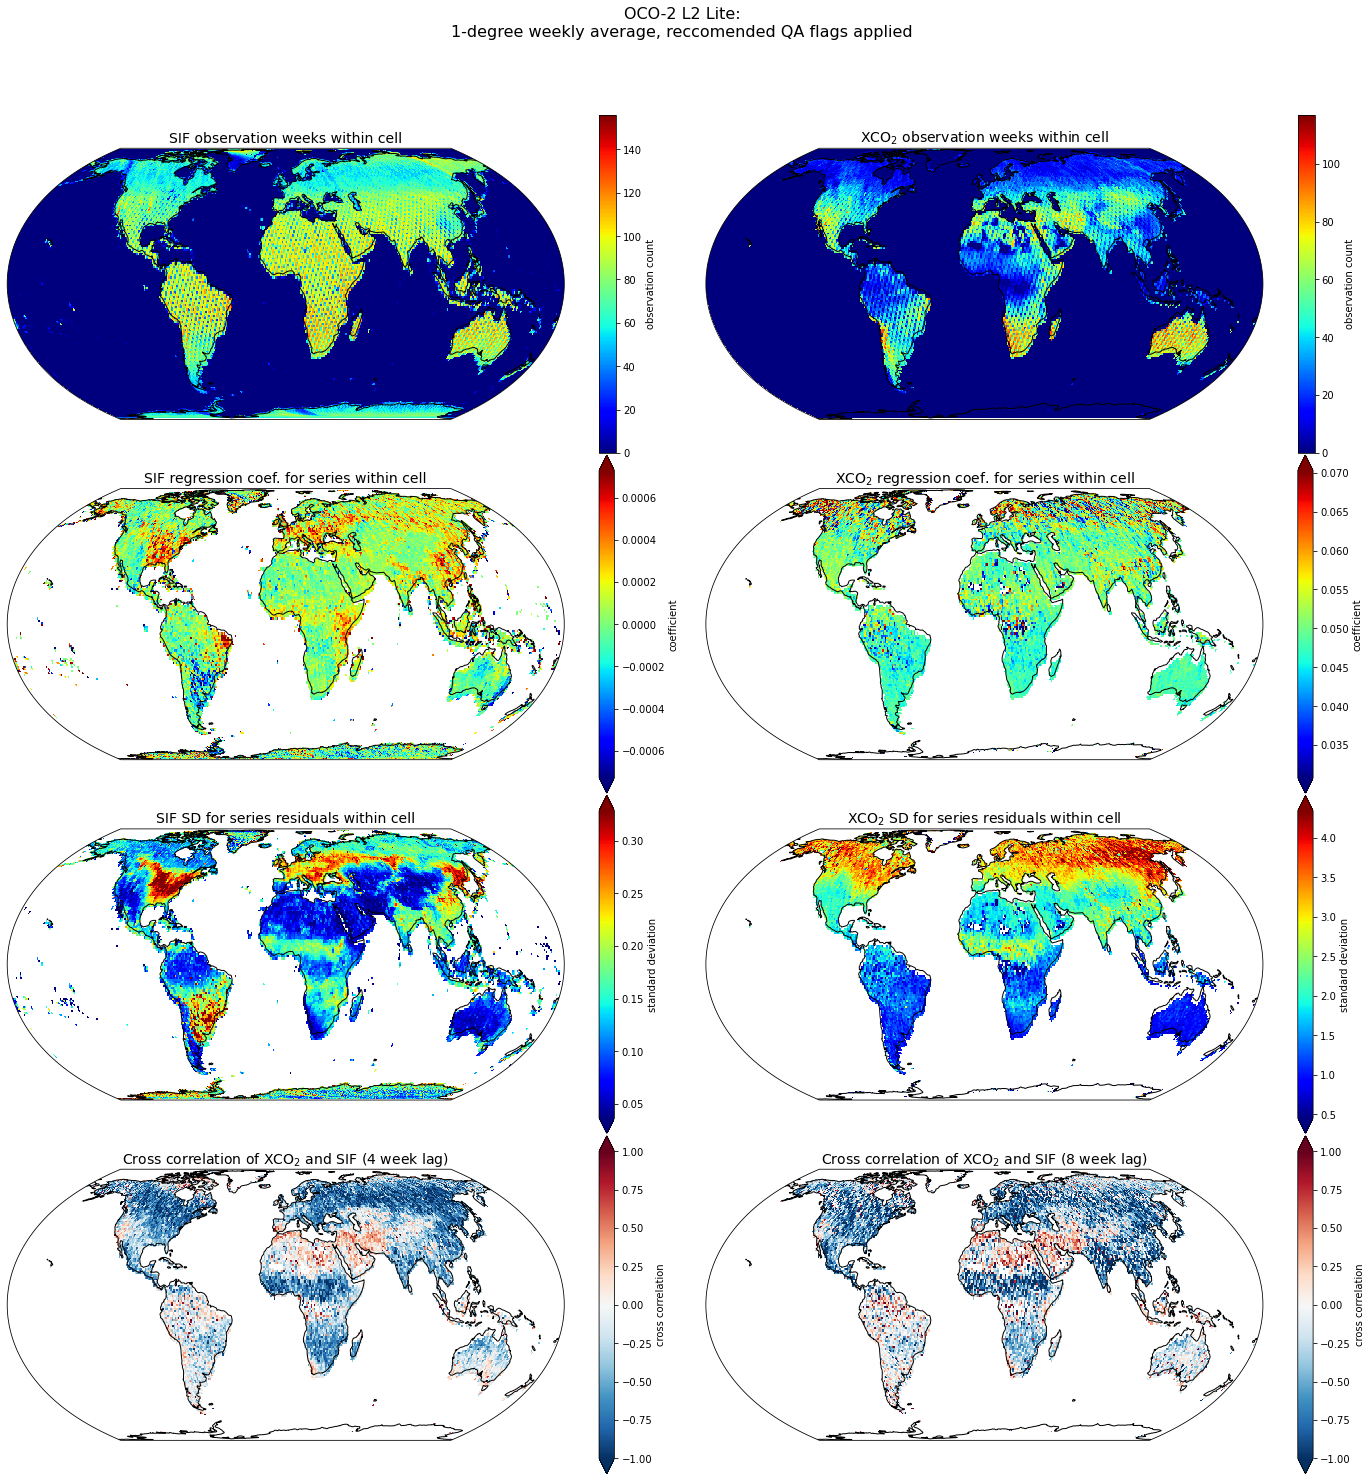

In [23]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "1-degree weekly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_count,
    title="SIF observation weeks within cell",
    ax=ax1,
    cbar_kwargs={"label": "observation count"},
    robust=False
)
plot.plot_da(
    DS_grid_weekly.xco2_count,
    title="XCO$_2$ observation weeks within cell",
    ax=ax2,
    cbar_kwargs={"label": "observation count"},
    robust=False
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_slope,
    title="SIF regression coef. for series within cell",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_weekly.xco2_slope,
    title="XCO$_2$ regression coef. for series within cell",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_std,
    title="SIF SD for series residuals within cell",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_weekly.xco2_std,
    title="XCO$_2$ SD for series residuals within cell",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (4 week lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_weekly.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (8 week lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/1deg_weekly_panel.png");